# Edge orientation and morphology 

**Objectives:**
* Calculating edge orientation for grayscale images
* Applying morphological transforms for document skew estimation

## Importing important packages and libraries ##

In [1]:
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt

img = cv.imread('D:/Deakin University (Applied AI (Professional)/SIT789 (Applications of Computer Vision and Speech Processing)/Tasks & Assignments/Task-2.2C/Resources_2.2/fisherman.jpg') #load image
img_gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

## 1. Calculating edge orientation ##

In [2]:
D_x = np.float32([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]]) / 8
der_x = cv.filter2D(img_gray, cv.CV_32F, D_x) #the 2nd parameter of filter2D is set to CV_32F to store negative values

D_y = np.float32([[-1, -2, -1], [0, 0, 0], [1, 2, 1]]) / 8
der_y = cv.filter2D(img_gray, cv.CV_32F, D_y) #the 2nd parameter of filter2D is set to CV_32F to store negative values

In [3]:
import math

height, width = img_gray.shape
ori_img_gray = np.zeros((height, width), np.float32) #gradient orientation of img_gray

for i in range(0, height):
    for j in range(0, width):
        if (der_x[i, j] and der_y[i, j] == 0):        
            ori_img_gray[i, j] = math.inf
        else:
            ori_img_gray[i, j] = math.atan2(der_y[i, j], der_x[i, j])
            ori_img_gray[i, j] = int((ori_img_gray[i, j]*180) / math.pi + 90)
        if (ori_img_gray[i, j] >= -90 and ori_img_gray[i, j] < 0):
            ori_img_gray[i, j] = ori_img_gray[i, j] + 360
                             

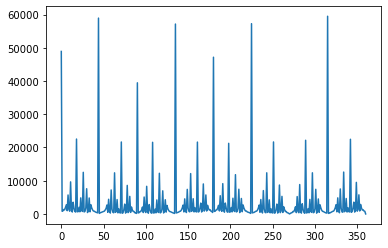

In [4]:
fish_hist = cv.calcHist([ori_img_gray], [0], None, [361], [0, 360]).flatten()
plt.plot(fish_hist)
plt.savefig('Fisherman_histogram')
plt.show()               

## Calculating an edge orientation histogram for the image in "empire.jpg" ##

In [5]:
img12 = cv.imread('D:\Deakin University (Applied AI (Professional)\SIT789 (Applications of Computer Vision and Speech Processing)\Tasks & Assignments\Task-2.1P\Resources_2.1\empire.jpg') #load image
img_gray12 = cv.cvtColor(img12, cv.COLOR_BGR2GRAY)

In [6]:
D_x1 = np.float32([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]]) / 8
der_x1 = cv.filter2D(img_gray12, cv.CV_32F, D_x) #the 2nd parameter of filter2D is set to CV_32F to store negative values

D_y1 = np.float32([[-1, -2, -1], [0, 0, 0], [1, 2, 1]]) / 8
der_y1 = cv.filter2D(img_gray12, cv.CV_32F, D_y) #the 2nd parameter of filter2D is set to CV_32F to store negative values

In [7]:
import math

height, width = img_gray12.shape
ori_img_gray12 = np.zeros((height, width), np.float32) #gradient orientation of img_gray12

for i in range(0, height):
    for j in range(0, width):
        if (der_x1[i, j] and der_y1[i, j] == 0):        
            ori_img_gray12[i, j] = math.inf
        else:
            ori_img_gray12[i, j] = math.atan2(der_y1[i, j], der_x1[i, j])
            ori_img_gray12[i, j] = int((ori_img_gray12[i, j]*180) / math.pi + 90)
        if (ori_img_gray12[i, j] >= -90 and ori_img_gray12[i, j] < 0):
            ori_img_gray12[i, j] = ori_img_gray12[i, j] + 360
                             

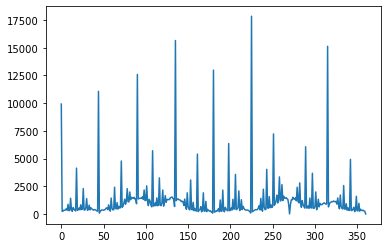

In [8]:
empire_hist = cv.calcHist([ori_img_gray12], [0], None, [361], [0, 360]).flatten()
plt.plot(empire_hist)
plt.savefig('Empire_histogram')
plt.show()

In [63]:
def chi_square(hist1, hist2):
    result = 0
    n = len(hist1)
    for i in range(0, n):
        result+= ((hist1[i] - hist2[i]) ** 2) / (hist1[i] + hist2[i] + 0.00001)
    return result

In [64]:
Match = chi_square(fish_hist, empire_hist)
print(Match)

484082.59901827684


Both the image 'fisherman.jpg' and 'empire.jpg' is not that much correlated as both have different pixel density or count, shape and dimensions. The histogram range of 'fisherman' image is also relatively high as compared to 'empire' image.

## 2. Applying morphology for document skew estimation ##

### 2.1. Binary images ###

In [9]:
doc = cv.imread('D:\Deakin University (Applied AI (Professional)\SIT789 (Applications of Computer Vision and Speech Processing)\Tasks & Assignments\Task-2.2C\Resources_2.2\doc.jpg', 0) #Note that the second parameter of imread is set to 0

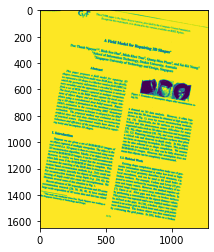

In [11]:
threshold = 200
ret, doc_bin = cv.threshold(doc, threshold, 255, cv.THRESH_BINARY)
plt.imshow(doc_bin)

In [13]:
cv.imwrite('binary_docversion.png', doc_bin)

True

### 2.2. Morphological transforms for document skew estimation ###

#### Step 1: Applying morphological transforms to merge letters in words and words in text lines. To do so, we first apply closing operation with the following structuring element ####

In [14]:
closing_se = np.ones((1, 15), np.int) #structuring element for closing

In [15]:
doc_bin = 255 - doc_bin #convert black/white to white/black

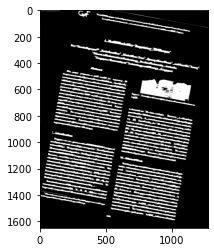

In [16]:
closing = cv.morphologyEx(doc_bin, cv.MORPH_CLOSE, closing_se)
plt.imshow(closing, 'gray')

In [17]:
cv.imwrite('closing_doc.png', closing)

True

In [18]:
opening_se = np.ones((8, 8), np.int) #structuring element for opening

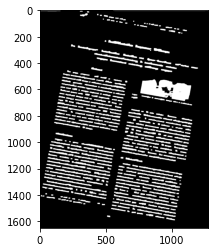

In [19]:
opening = cv.morphologyEx(closing, cv.MORPH_OPEN, opening_se)
plt.imshow(opening, 'gray')

In [20]:
cv.imwrite('opening_doc.png', opening)

True

#### Step 2. Extract merged text lines using connected component labelling technique where each text line corresponds to a connected component. ####

In [21]:
# connected component labelling
num_labels, labels_im = cv.connectedComponents(opening)

In [22]:
def ExtractConnectedComponents(num_labels, labels_im):
    connected_components = [[] for i in range(0, num_labels)]
    
    height, width = labels_im.shape
    for i in range(0, height):
        for j in range(0, width):
            if labels_im[i, j] >= 0:
                connected_components[labels_im[i, j]].append((j, i))
                
    return connected_components


In [23]:
connected_components = ExtractConnectedComponents(num_labels, labels_im)

#### Step 3. Find the orientation for connected components (i.e., text lines) using least squares regression. ####

In [24]:
import math
def FindOrientation(cc):
    mx = 0
    my = 0
    mxx = 0
    myy = 0
    mxy = 0
    
    for i in range(0, len(cc)):
        mx += cc[i][0] # cc[i][0] is used to store the x coordinate of pixel cc[i]
        my += cc[i][1] # cc[i][1] is used to store the y coordinate of pixel cc[i]
    mx /= len(cc)
    my /= len(cc)
    
    for i in range(0, len(cc)):
        dx = cc[i][0] - mx
        dy = cc[i][1] - my
        mxx += (dx * dx)
        myy += (dy * dy)
        mxy += (dx * dy)
        
    mxx /= len(cc)
    myy /= len(cc)
    mxy /= len(cc)
    
    theta = - math.atan2(2 * mxy, mxx - myy) / 2
    return theta


In [25]:
orientations = np.zeros(num_labels, np.float32)
for i in range(0, num_labels):
    orientations[i] = FindOrientation(connected_components[i])

#### Step 4. The orientation of the entire document is computed as the median of the orientations of all text lines. We will call median method from statistics to get this median. ####

In [26]:
import statistics
orientation = statistics.median(orientations)

#### Step 5. We now deskew the image in doc by rotating it with an angle of -orientation. ####

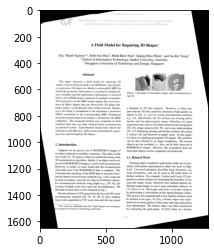

In [27]:
# rotate image
height, width = doc.shape
c_x = (width - 1) / 2.0 # column index varies in [0, width-1]
c_y = (height - 1) / 2.0 # row index varies in [0, height-1]
c = (c_x, c_y) # A point is defined by x and y coordinate

M = cv.getRotationMatrix2D(c, -orientation * 180 / math.pi, 1)
doc_deskewed = cv.warpAffine(doc, M, (width, height))
plt.imshow(doc_deskewed, 'gray')


In [28]:
cv.imwrite('deskewed_doc.png', doc_deskewed)

True

## Applying the same methodology, deskew the document image in doc_1.jpg ##

In [29]:
doc_1 = cv.imread('D:\Deakin University (Applied AI (Professional)\SIT789 (Applications of Computer Vision and Speech Processing)\Tasks & Assignments\Task-2.2C\Resources_2.2\doc_1.jpg', 0) #Note that the second parameter of imread is set to 0

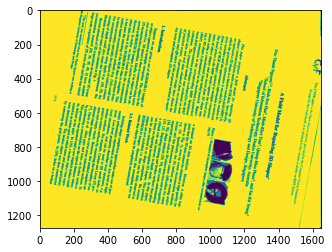

In [30]:
threshold = 200
ret, doc_bin = cv.threshold(doc_1, threshold, 255, cv.THRESH_BINARY)
plt.imshow(doc_bin)

In [31]:
cv.imwrite('binary_doc_1.png', doc_bin)

True

In [32]:
closing_se = np.ones((1, 15), np.int) #structuring element for closing

In [33]:
doc_bin = 255 - doc_bin #convert black/white to white/black

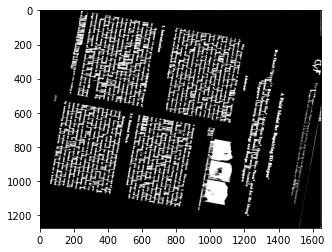

In [34]:
closing = cv.morphologyEx(doc_bin, cv.MORPH_CLOSE, closing_se)
plt.imshow(closing, 'gray')

In [36]:
cv.imwrite('closing_doc_1.png', closing)

True

In [37]:
opening_se = np.ones((8, 8), np.int) #structuring element for opening

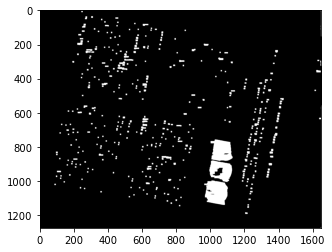

In [38]:
opening = cv.morphologyEx(closing, cv.MORPH_OPEN, opening_se)
plt.imshow(opening, 'gray')

In [39]:
cv.imwrite('opening_doc_1.png', opening)

True

In [40]:
# connected component labelling
num_labels, labels_im = cv.connectedComponents(opening)

In [41]:
connected_components = ExtractConnectedComponents(num_labels, labels_im)

In [42]:
orientations = np.zeros(num_labels, np.float32)
for i in range(0, num_labels):
    orientations[i] = FindOrientation(connected_components[i])

In [43]:
orientation = statistics.median(orientations)

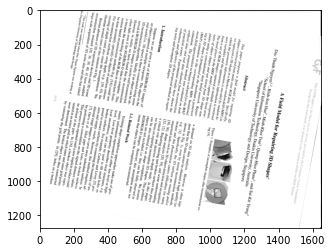

In [44]:
# rotate image
height, width = doc_1.shape
c_x = (width - 1) / 2.0 # column index varies in [0, width-1]
c_y = (height - 1) / 2.0 # row index varies in [0, height-1]
c = (c_x, c_y) # A point is defined by x and y coordinate

M = cv.getRotationMatrix2D(c, -orientation * 180 / math.pi, 1)
doc_deskewed12 = cv.warpAffine(doc_1, M, (width, height))
plt.imshow(doc_deskewed12, 'gray')

In [45]:
cv.imwrite('deskewed_doc_1.png', doc_deskewed12)

True

### Fixing the Image ###

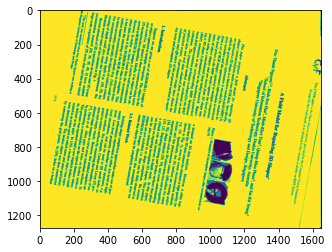

In [49]:
threshold = 200
ret, doc_bin = cv.threshold(doc_1, threshold, 255, cv.THRESH_BINARY)
plt.imshow(doc_bin)

In [50]:
closing_se = np.ones((15, 1), np.int) #structuring element for closing

In [51]:
doc_bin = 255 - doc_bin #convert black/white to white/black

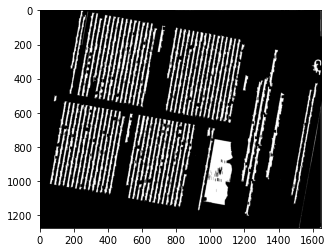

In [52]:
closing = cv.morphologyEx(doc_bin, cv.MORPH_CLOSE, closing_se)
plt.imshow(closing, 'gray')

In [53]:
cv.imwrite('fixclosing_doc_1.png', closing)

True

In [54]:
opening_se = np.ones((8, 8), np.int) #structuring element for opening

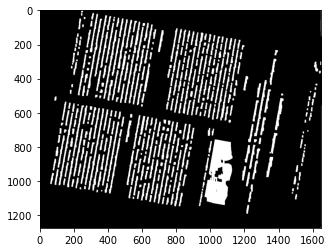

In [55]:
opening = cv.morphologyEx(closing, cv.MORPH_OPEN, opening_se)
plt.imshow(opening, 'gray')

In [56]:
cv.imwrite('fixopening_doc_1.png', opening)

True

In [57]:
# connected component labelling
num_labels, labels_im = cv.connectedComponents(opening)

In [58]:
connected_components = ExtractConnectedComponents(num_labels, labels_im)

In [59]:
orientations = np.zeros(num_labels, np.float32)
for i in range(0, num_labels):
    orientations[i] = FindOrientation(connected_components[i])

In [60]:
orientation = statistics.median(orientations)

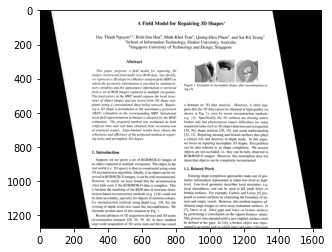

In [61]:
# rotate image
height, width = doc_1.shape
c_x = (width - 1) / 2.0 # column index varies in [0, width-1]
c_y = (height - 1) / 2.0 # row index varies in [0, height-1]
c = (c_x, c_y) # A point is defined by x and y coordinate

M = cv.getRotationMatrix2D(c, -orientation * 180 / math.pi - 180, 1)
fixdoc_deskewed_1 = cv.warpAffine(doc_1, M, (width, height))
plt.imshow(fixdoc_deskewed_1, 'gray')

In [62]:
cv.imwrite('fixdoc_deskewed_1.png', fixdoc_deskewed_1)

True

If we apply the same structing element for the 'doc_1' image then using the method, the image will become very unclear and will not deskew properly as the structuring element is different for every image. In order to fix the method we'll first use the vertical structing element instead of horizontal structing element, then we can see that the opening and closing version of doc_1 is much clear. At the end we'll get the deskewed image as upside down but clear and well aligned and for the image to be fixed we just add -180 to 'math.pi' and we'll get the deskewed image we require.